### Import Packages

In [7]:
import pandas as pd
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input, LeakyReLU, BatchNormalization, Dropout, Flatten
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow_addons.metrics import F1Score

In [8]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


### Read labels

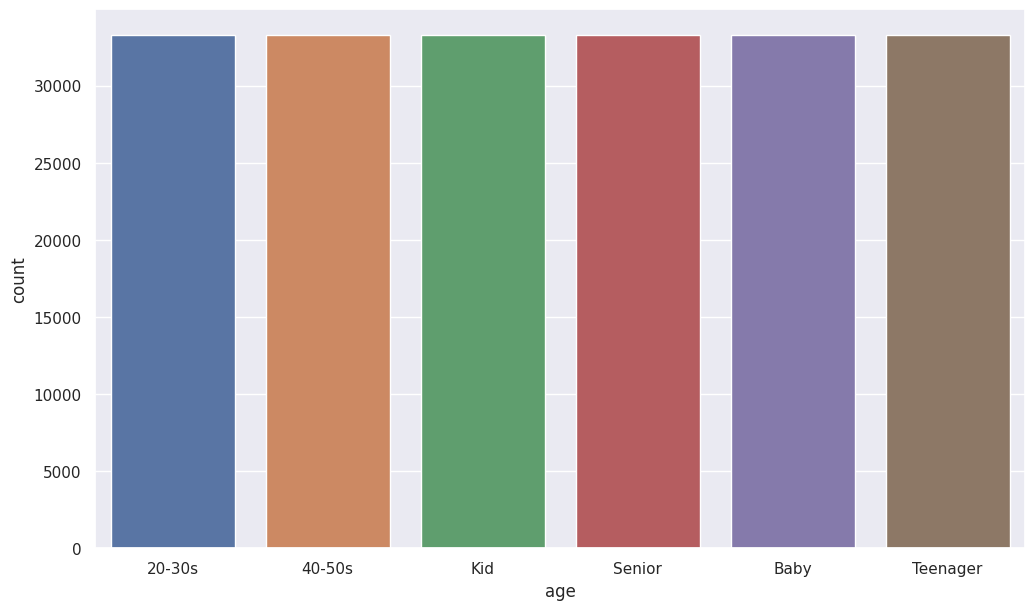

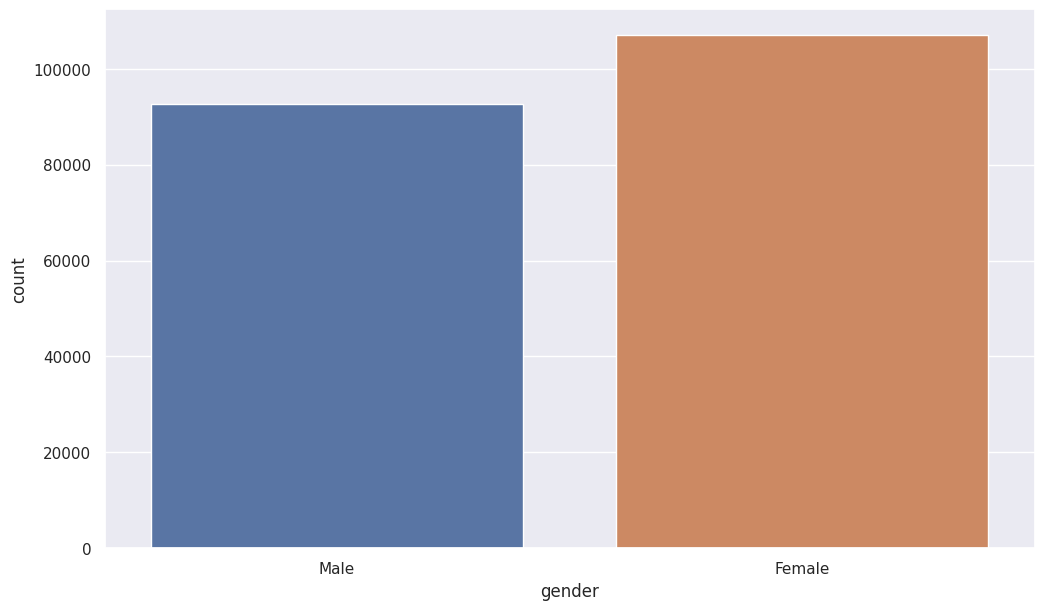

In [107]:
# Load CSV file
labels_df = pd.read_csv('balanced_plus_data_utk_labels.csv')
plt.figure(figsize=(12,7))
sns.set(style="darkgrid")
ax = sns.countplot(x="age", data=labels_df)
plt.figure(figsize=(12,7))
sns.set(style="darkgrid")
ax = sns.countplot(x="gender", data=labels_df)

In [108]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.7, random_state=1)
for train_index, validation_index in sss.split(labels_df['file_name'], labels_df['age']):
    train_df, _ = labels_df.iloc[train_index], labels_df.iloc[validation_index]

print("train_df shape: {}".format(train_df.shape))

train_df shape: (59934, 4)


In [109]:
labels_df = train_df

In [110]:
labels_df.shape

(59934, 4)

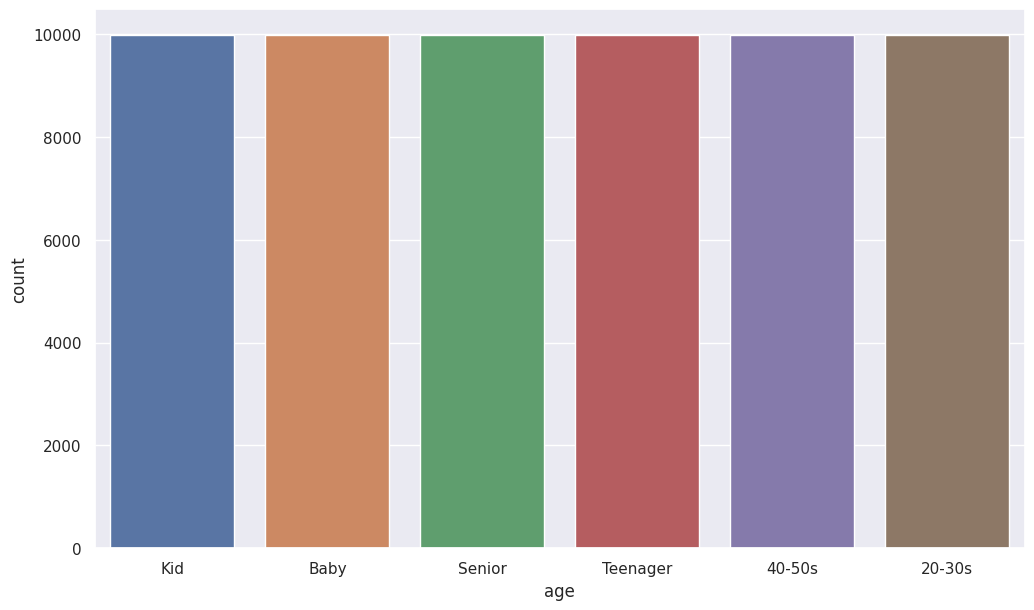

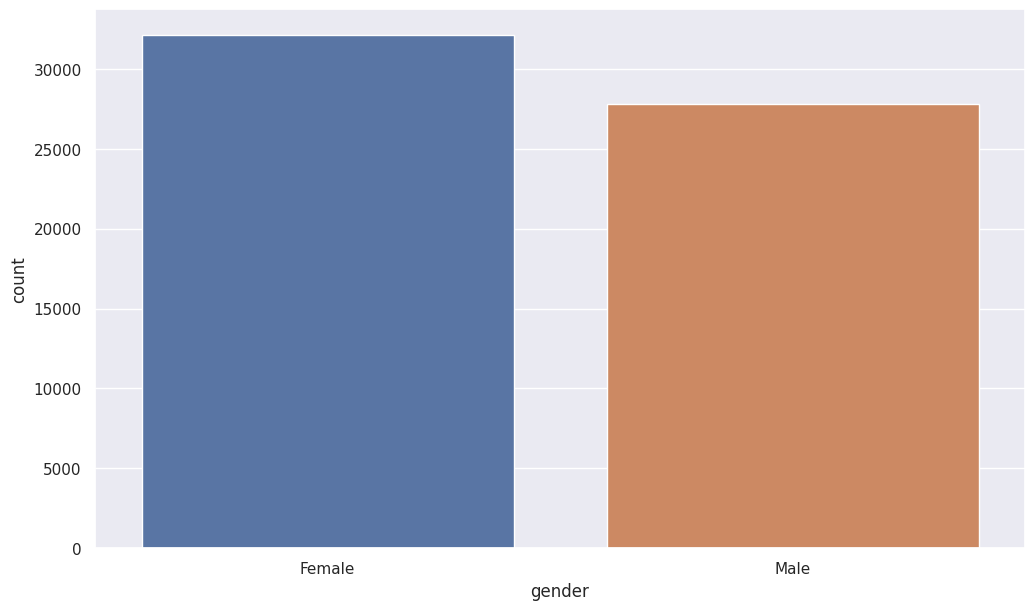

In [111]:
plt.figure(figsize=(12,7))
sns.set(style="darkgrid")
ax = sns.countplot(x="age", data=labels_df)
plt.figure(figsize=(12,7))
sns.set(style="darkgrid")
ax = sns.countplot(x="gender", data=labels_df)

### Model Hyperparameters

In [9]:
train_dataset_dir = "BalancedPlusDataUTK"
val_dataset_dir = "BalancedPlusDataUTK"
mini_batch_size = 32
image_dim = (224, 224, 3)
val_split=0.15
num_of_epochs = 275
save_model_name = "age_gender_224_1.h5"
pretrained_weights = "age_gender_CLAHE_224.h5"

In [113]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=val_split, random_state=1)
for train_index, validation_index in sss.split(labels_df['file_name'], labels_df['age']):
    train_df, validation_df = labels_df.iloc[train_index], labels_df.iloc[validation_index]

print("train_df shape: {}".format(train_df.shape))
print("validation_df shape: {}".format(validation_df.shape))

train_df shape: (50943, 4)
validation_df shape: (8991, 4)


In [114]:
train_df.head()

,source,file_name,age,gender
161950,utk,28762_1_0_2_20161219200242220.jpg.chip.jpg,Baby,Male
199217,utk,16_0_0_20170110232741392.jpg.chip.jpg,Teenager,Male
184177,public_train,17692_12656_88383300.jpg,Teenager,Female
132494,utk,83_0_0_20170111211106903.jpg.chip.jpg,Senior,Male
54616,public_train,21319_1010_1879870.jpg,40-50s,Male


In [115]:
# Map age ranges to numeric labels
age_mapping = {'20-30s': 0, '40-50s': 1, 'Baby': 2, 'Kid': 3, 'Senior': 4, 'Teenager': 5}
gender_mapping = {'Male': 0, 'Female': 1}

train_df['age'] = train_df['age'].map(age_mapping)

# Convert age labels to categorical
train_df['age'] = train_df['age'].apply(lambda x: to_categorical(x, num_classes=6))

train_df['gender'] = train_df['gender'].map(gender_mapping)

# Ensure that 'gender' is numeric
train_df['gender'] = train_df['gender'].astype(int)

validation_df['age'] = validation_df['age'].map(age_mapping)

# Convert age labels to categorical
validation_df['age'] = validation_df['age'].apply(lambda x: to_categorical(x, num_classes=6))

validation_df['gender'] = validation_df['gender'].map(gender_mapping)

# Ensure that 'gender' is numeric
validation_df['gender'] = validation_df['gender'].astype(int)

/home/phucphan/miniconda3/envs/face_detection/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/home/phucphan/miniconda3/envs/face_detection/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/home/phucphan/miniconda3/envs/face_detection/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

In [116]:
train_df.head()

,source,file_name,age,gender
161950,utk,28762_1_0_2_20161219200242220.jpg.chip.jpg,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0]",0
199217,utk,16_0_0_20170110232741392.jpg.chip.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",0
184177,public_train,17692_12656_88383300.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0]",1
132494,utk,83_0_0_20170111211106903.jpg.chip.jpg,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0]",0
54616,public_train,21319_1010_1879870.jpg,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0]",0


### Config image generators

In [117]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=val_split
)


train_generator = train_datagen.flow_from_dataframe(
    train_df,
    directory = train_dataset_dir,
    x_col = 'file_name',
    y_col = ['age', 'gender'],
    class_mode = 'multi_output',
    target_size = (image_dim[0], image_dim[1]),
    interpolation="bicubic",
    batch_size = mini_batch_size
)


validation_datagen = ImageDataGenerator(rescale=1./255, validation_split=val_split)

validation_generator = validation_datagen.flow_from_dataframe(
    validation_df,
    directory = val_dataset_dir,
    x_col='file_name',
    y_col=['age', 'gender'],
    target_size = (image_dim[0], image_dim[1]),
    batch_size = mini_batch_size,
    class_mode = "multi_output",
    interpolation="bicubic",
    shuffle=False
)


Found 50943 validated image filenames.
Found 8991 validated image filenames.


### Build and validate the model


In [118]:

def build_model():
    # Load the ResNet50 model, pre-trained on ImageNet
    base_model = ResNet50(input_tensor=Input(shape=image_dim), include_top=False, weights='imagenet')
    
    # Freeze the layers of the base model
    for layer in base_model.layers:
        layer.trainable = False

    # Set batch normalization layers to inference mode
    for layer in base_model.layers:
        if "BatchNormalization" in str(layer):
            layer.trainable = True
            layer._per_input_updates = {}

    # Add global average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    # Simplified common layers
    x = BatchNormalization()(x)
    x = Flatten()(x)

    # Simplified branch for age prediction
    age_x = Dense(256, activation='relu')(x)  # Reduced number of neurons
    age_x = Dropout(0.5)(age_x)
    age_output = Dense(6, activation='softmax', name='age_output')(age_x)

    # Simplified branch for gender prediction
    gender_x = Dense(32, activation='relu')(x)  # Reduced number of neurons
    gender_x = Dropout(0.5)(gender_x)
    gender_output = Dense(1, activation='sigmoid', name='gender_output')(gender_x)

    # Create the model
    model = Model(inputs=base_model.input, outputs=[age_output, gender_output])
    
    # Load the pre-trained model
    pretrain_model = load_model(pretrained_weights)

    # Transfer weights from pre-trained model
    model.set_weights(pretrain_model.get_weights())

    return model


# Final model
model = build_model()
model.summary()


# Compile the model
model.compile(optimizer='adam', 
              loss={'age_output': 'categorical_crossentropy', 'gender_output': 'binary_crossentropy'},
              metrics={'age_output': [F1Score(num_classes=6, average='weighted'), 
                       'categorical_accuracy'], 'gender_output': 'accuracy'})


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                            

In [119]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True) 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=7, verbose=1, mode='min')
save_best = ModelCheckpoint(save_model_name, monitor='val_loss', save_best_only=True, mode='min')  

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=num_of_epochs,
    verbose=1, 
    workers=5,
    steps_per_epoch=int(np.ceil(train_generator.samples // train_generator.batch_size)),
    validation_steps=int(np.ceil(validation_generator.samples // validation_generator.batch_size)),
    callbacks=[early_stopping, reduce_lr, save_best]
)

Epoch 1/275
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
1591/1591 [==============================] - ETA: 0s - loss: 0.9955 - age_output_loss: 0.7079 - gender_output_loss: 0.2877 - age_output_f1_score: 0.7039 - age_output_categorical_accuracy: 0.7034 - gender_output_accuracy: 0.8700WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7fe186d2cb90> and will run 

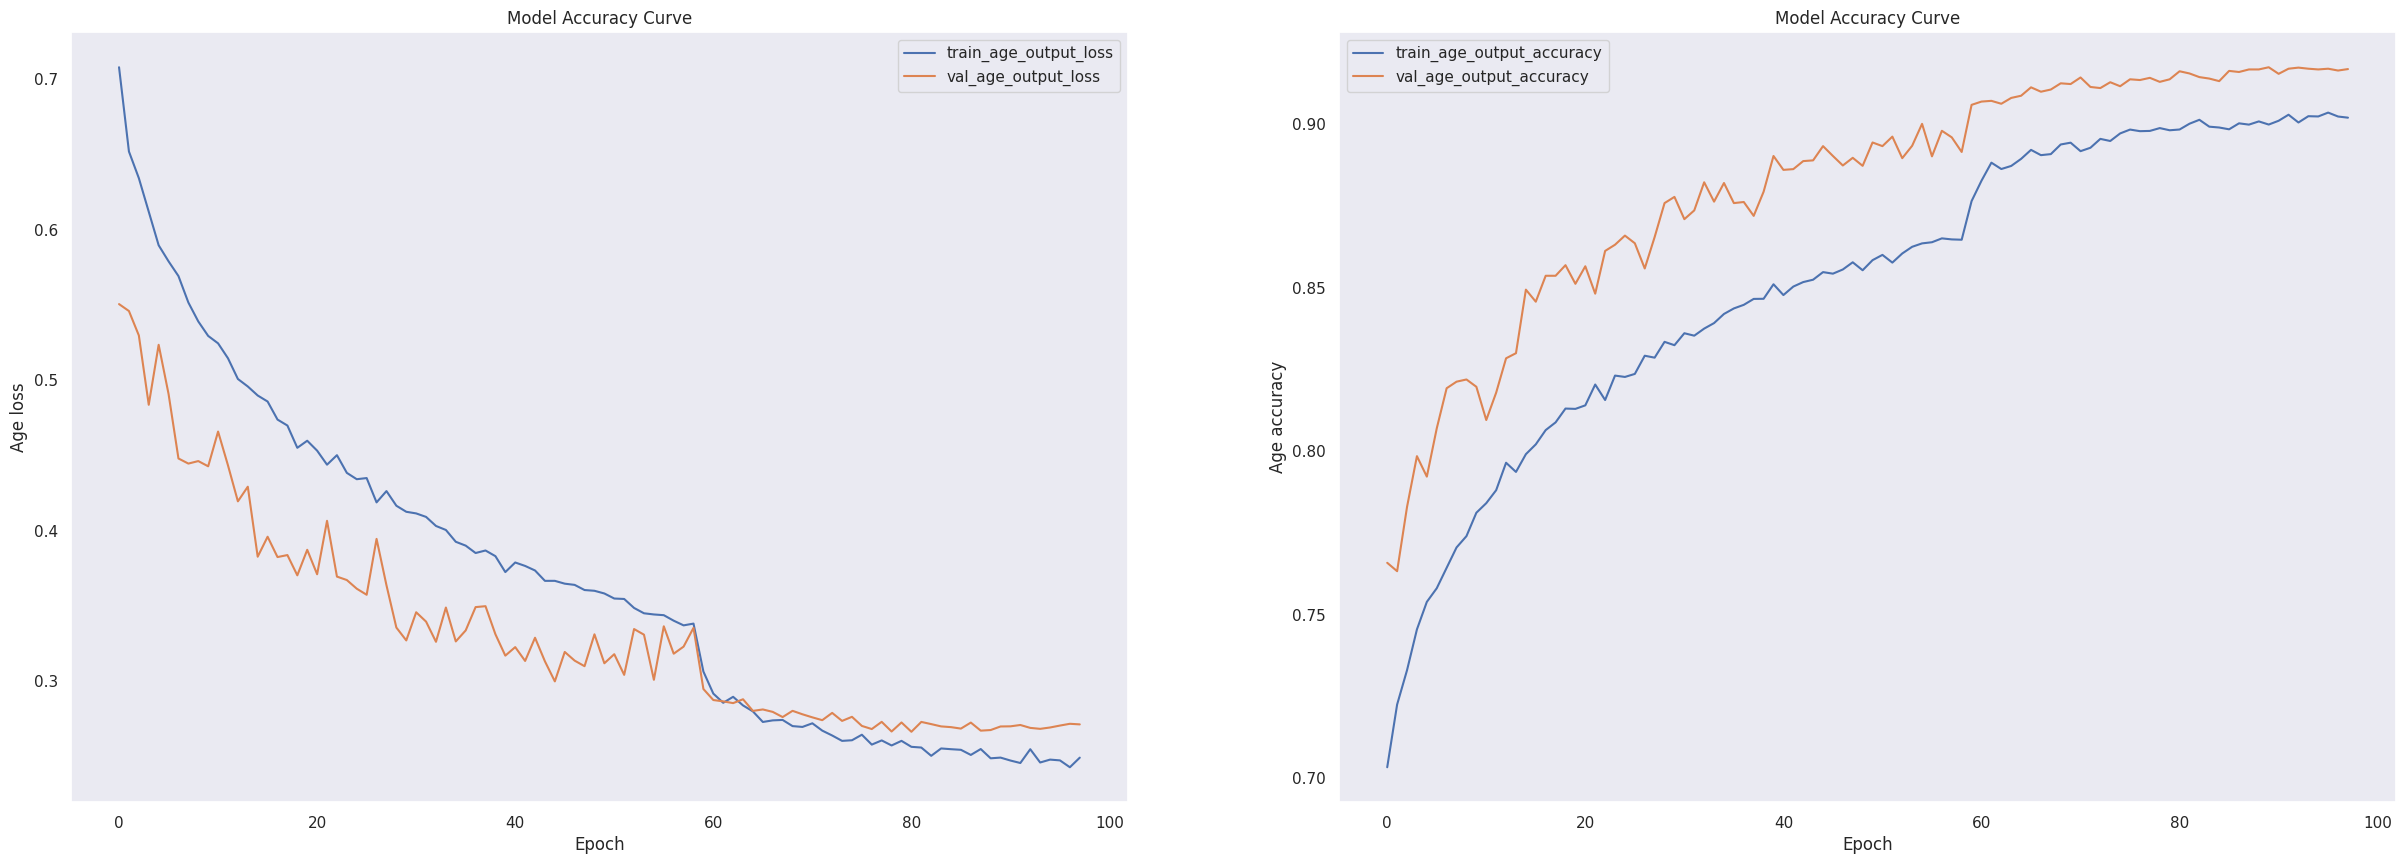

In [122]:
_, ax = plt.subplots(1, 2, figsize=(30, 10))


ax[0].plot(history.history['age_output_loss'], label='train_age_output_loss')
ax[0].plot(history.history['val_age_output_loss'], label='val_age_output_loss')
ax[0].set_ylabel('Age loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title("Model Accuracy Curve")
ax[0].legend()
ax[0].grid()

ax[1].plot(history.history['age_output_categorical_accuracy'], label='train_age_output_accuracy')
ax[1].plot(history.history['val_age_output_categorical_accuracy'], label='val_age_output_accuracy')
ax[1].set_ylabel('Age accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_title("Model Accuracy Curve")
ax[1].legend()
ax[1].grid()



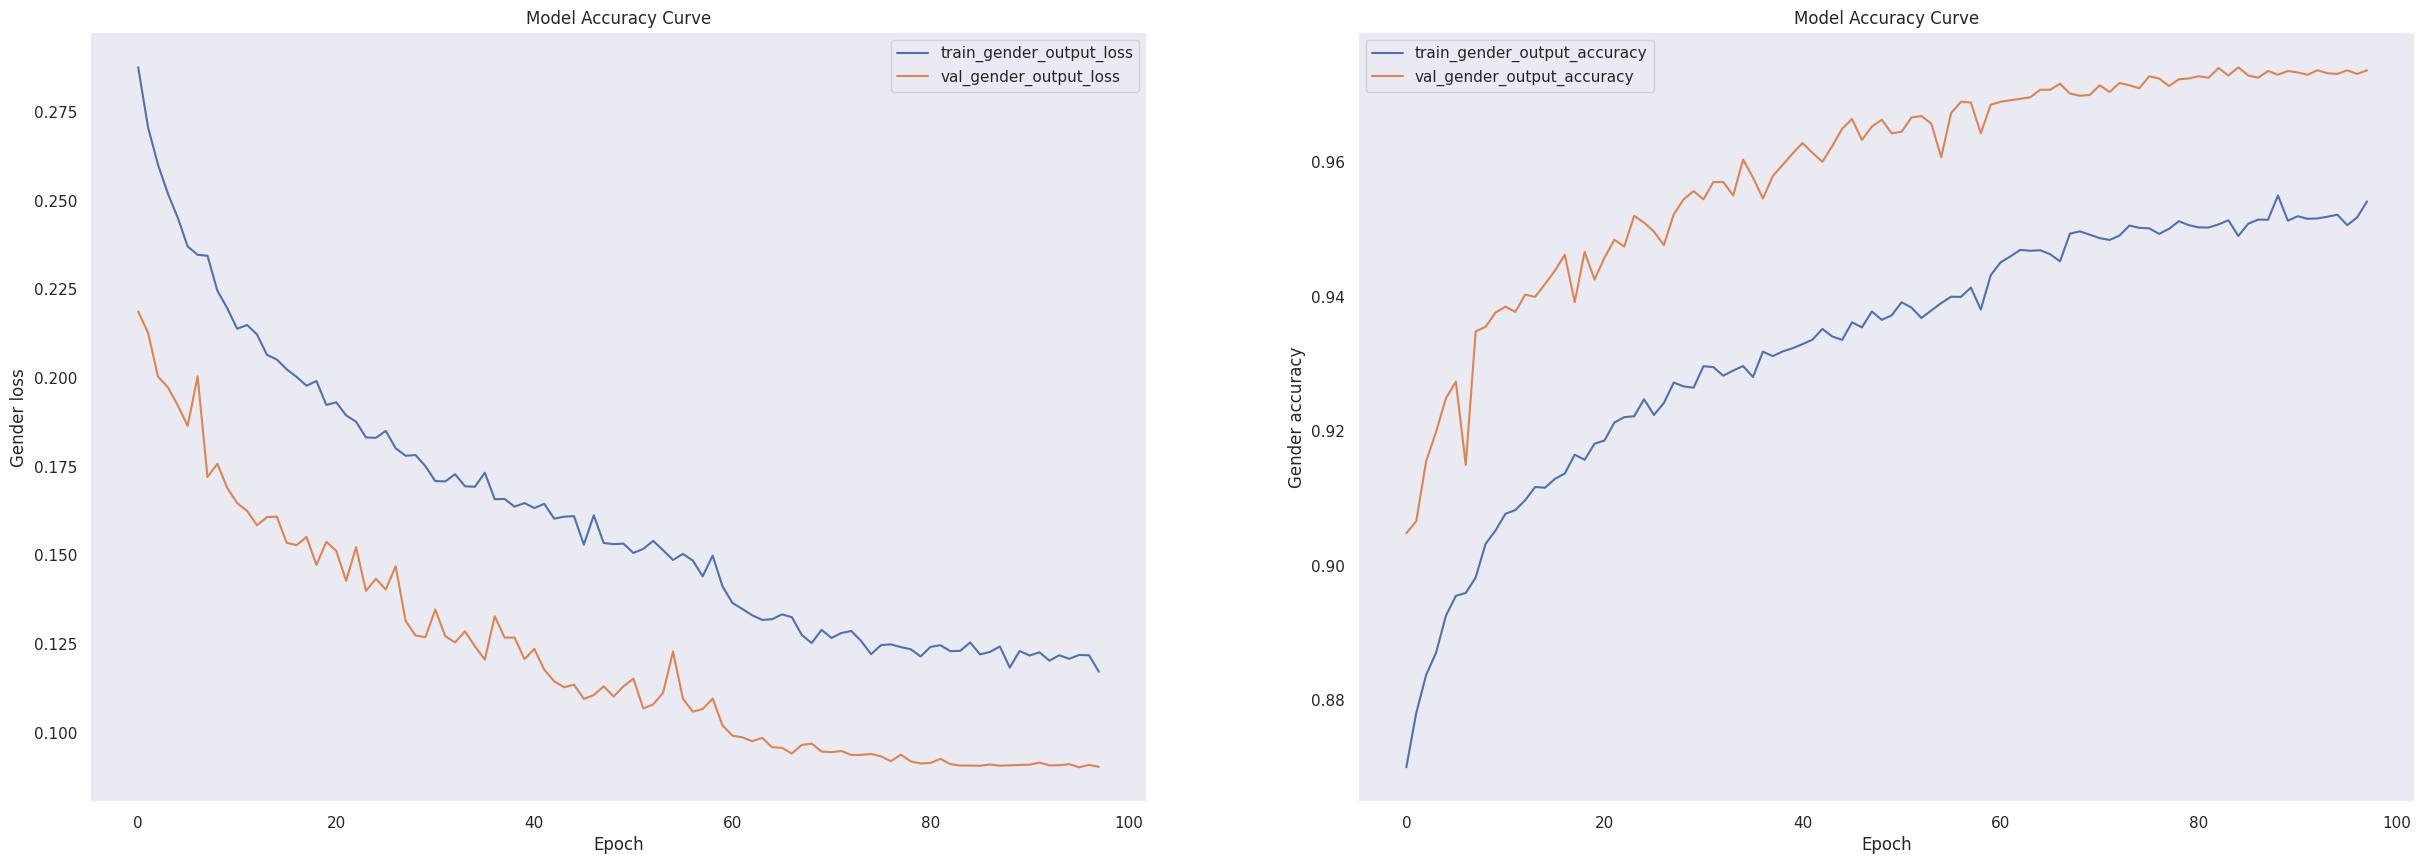

In [123]:
_, ax = plt.subplots(1, 2, figsize=(30, 10))


ax[0].plot(history.history['gender_output_loss'], label='train_gender_output_loss')
ax[0].plot(history.history['val_gender_output_loss'], label='val_gender_output_loss')
ax[0].set_ylabel('Gender loss')
ax[0].set_xlabel('Epoch')
ax[0].set_title("Model Accuracy Curve")
ax[0].legend()
ax[0].grid()

ax[1].plot(history.history['gender_output_accuracy'], label='train_gender_output_accuracy')
ax[1].plot(history.history['val_gender_output_accuracy'], label='val_gender_output_accuracy')
ax[1].set_ylabel('Gender accuracy')
ax[1].set_xlabel('Epoch')
ax[1].set_title("Model Accuracy Curve")
ax[1].legend()
ax[1].grid()



### Check classification report

In [163]:
model = load_model('age_gender_224_1.h5')

In [126]:
# Evaluate the model
results = model.evaluate(validation_generator, steps=int(np.ceil(validation_generator.samples // validation_generator.batch_size)))

# Display the results
print("Test Loss for Age:", results[1])
print("Test Accuracy for Age:", results[4])
print("Test F1 Score for Age:", results[3])
print("Test Loss for Gender:", results[2])
print("Test Accuracy for Gender:", results[5])

280/280 [==============================] - 30s 105ms/step - loss: 0.3577 - age_output_loss: 0.2670 - gender_output_loss: 0.0906 - age_output_f1_score: 0.9165 - age_output_categorical_accuracy: 0.9166 - gender_output_accuracy: 0.9735
Test Loss for Age: 0.2670201361179352
Test Accuracy for Age: 0.9166294932365417
Test F1 Score for Age: 0.9164736270904541
Test Loss for Gender: 0.0906434878706932
Test Accuracy for Gender: 0.9735491275787354


In [127]:
from sklearn.metrics import classification_report

# Generate predictions for the validation set
predictions = model.predict(validation_generator)

# Convert one-hot encoded age labels back to numerical labels
true_age_labels = np.argmax(validation_generator.labels[0], axis=1)
predicted_age_labels = np.argmax(predictions[0], axis=1)

# Convert gender predictions to binary labels (0 or 1)
true_gender_labels = validation_generator.labels[1]
predicted_gender_labels = np.round(predictions[1])

# Classification report for age
print("Classification Report for Age:")
print(classification_report(true_age_labels, predicted_age_labels, target_names=age_mapping.keys()))

# Classification report for gender
print("\nClassification Report for Gender:")
print(classification_report(true_gender_labels, predicted_gender_labels))



Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
281/281 [==============================] - 30s 104ms/step
Classification Report for Age:
              precision    recall  f1-score   support

      20-30s       0.84      0.83      0.84      1499
      40-50s       0.83      0.83      0.83      1498
        Baby       0.99      0.99      0.99      1498
         Kid       0.98      0.95      0.96      1499
      Senior      

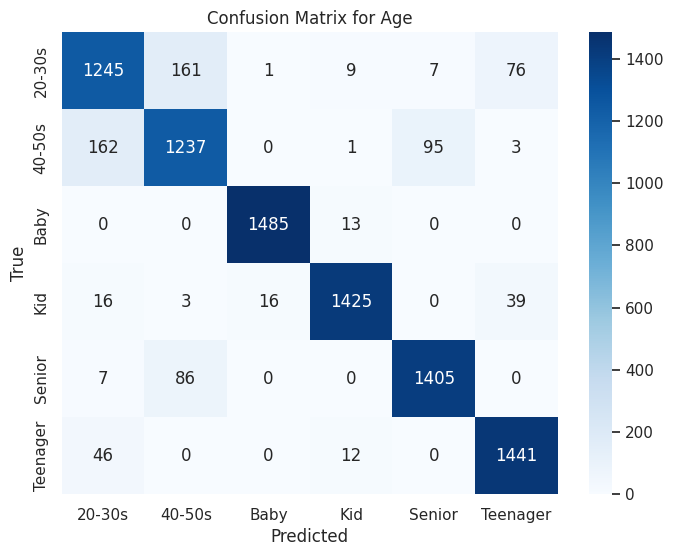

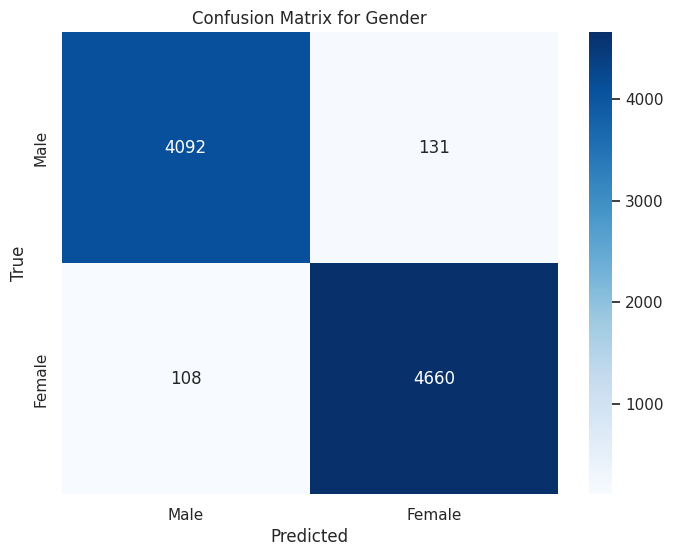

In [128]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Function to plot confusion matrix
def plot_confusion_matrix(true_labels, predicted_labels, target_names, title='Confusion Matrix'):
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=target_names, yticklabels=target_names)
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrix for age
plot_confusion_matrix(true_age_labels, predicted_age_labels, target_names=age_mapping.keys(), title='Confusion Matrix for Age')

# Plot confusion matrix for gender
plot_confusion_matrix(true_gender_labels, predicted_gender_labels, target_names=['Male', 'Female'], title='Confusion Matrix for Gender')


### Test

In [10]:
model = load_model('age_gender_224_1.h5')

In [11]:
test_df = pd.read_csv('answer_private_test.csv')
test_dir = "cropped_faces_private_test"
test_df.head()

,image_file,age,gender
0,private_test_img_1363_face_491_427.jpg,NaN,NaN
1,private_test_img_1363_face_829_369.jpg,NaN,NaN
2,private_test_img_2440_face_565_211.jpg,NaN,NaN
3,private_test_img_2756_face_340_105.jpg,NaN,NaN
4,private_test_img_741_face_240_203.jpg,NaN,NaN


In [12]:
test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    directory = test_dir,
    x_col='image_file',
    y_col=['age', 'gender'],
    shuffle=False,
    target_size = (image_dim[0], image_dim[1]),
    batch_size = mini_batch_size,
    class_mode = "multi_output",
    interpolation="bicubic"
)

Found 6754 validated image filenames.


In [13]:
# Generate predictions for the validation set
predictions = model.predict(test_generator)

2024-01-20 07:34:22.738467: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2024-01-20 07:34:25.187828: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:428] Loaded cuDNN version 8902
2024-01-20 07:34:25.426647: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:115] *** WARNING *** You are using ptxas 10.1.243, which is older than 11.1. ptxas before 11.1 is known to miscompile XLA code, leading to incorrect results or invalid-address errors.

You may not need to update to CUDA 11.1; cherry-picking the ptxas binary is often sufficient.


 21/212 [=>............................] - ETA: 22s

2024-01-20 07:34:29.467820: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.


 63/212 [=======>......................] - ETA: 16s

2024-01-20 07:34:34.128162: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.


 68/212 [========>.....................] - ETA: 16s

2024-01-20 07:34:34.753248: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.


 93/212 [============>.................] - ETA: 13s

2024-01-20 07:34:37.583179: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 19267584 exceeds 10% of free system memory.


212/212 [==============================] - 28s 112ms/step


In [14]:
# Convert one-hot encoded age labels back to numerical labels
predicted_age_labels = np.argmax(predictions[0], axis=1)

# Convert gender predictions to binary labels (0 or 1)
predicted_gender_labels = np.round(predictions[1])

In [15]:
# Map age ranges to numeric labels
age_mapping = {0:'20-30s', 1:'40-50s', 2:'Baby', 3:'Kid', 4:'Senior', 5:'Teenager'}
gender_mapping = {0:'Male', 1:'Female'}

In [16]:
test_df['age'] = predicted_age_labels

test_df['age'] = test_df['age'].map(age_mapping)
test_df['gender'] = predicted_gender_labels
test_df['gender'] = test_df['gender'].map(gender_mapping)
test_df.head()

,image_file,age,gender
0,private_test_img_1363_face_491_427.jpg,20-30s,Female
1,private_test_img_1363_face_829_369.jpg,40-50s,Male
2,private_test_img_2440_face_565_211.jpg,20-30s,Male
3,private_test_img_2756_face_340_105.jpg,20-30s,Male
4,private_test_img_741_face_240_203.jpg,Teenager,Male


In [17]:
test_df.to_csv("age_gender_answer.csv", index=False)